In [48]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import cv2

In [49]:
data_df = pd.read_csv('../../../data/sixth_df_input.csv')

In [50]:
final_model = {'max_depth': 10, 'min_sample_split': 2, 'min_sample_leaf': 15, 'max_features': 'sqrt'}

In [51]:
data_df = pd.read_csv('../../../data/sixth_df_input.csv')

data_df['Rank'] = data_df['Rank'].astype('int')
data_df.head()


dict_map_sex = {'men': 1, 'women': 0}
data_df['sex'] = data_df['sex'].map(dict_map_sex)

dict_map_format = {'sprint' : 0, 'pursuit': 1, 'individual': 2, 'mass_start': 3, 'sprint_2': 0, 'pursuit_2': 1}
data_df['format'] = data_df['format'].map(dict_map_format)

def rank_transform(x):
    if x == 1:
        return 0
    elif x == 2 or x == 3:
        return 1
    elif x > 3:
        return 2

data_df['Rank'] = data_df['Rank'].apply(rank_transform)

final_df = data_df[['season', 'Rank', 'distance', 'Behind', 'format', 'position', 'km_to_go', 'standing_remaining', 'prone_remaining', 'probability_standing',\
    'probability_prone', 'back_from_median', 'gradient_back', 'all_mistakes_prone', 'all_mistakes_standing', 'gradient_standing', 'gradient_prone',\
        'gradient_pos', 'behind_above', 'behind_below', 'standing_above', 'standing_below', 'prone_above', 'prone_below']]

final_df_train = final_df[final_df['season'] != '2021-2022']
final_df_test = final_df[final_df['season'] == '2021-2022']

final_df_train = final_df_train.drop(['season'], axis = 1)
final_df_test = final_df_test.drop(['season'], axis = 1)


weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes = np.unique(final_df_train['Rank']), y = final_df_train['Rank'])

weights_dict = {'0': weights[0], '1': weights[1], '2': weights[2]}

final_df_test = final_df_test.drop(columns = ['distance'])
final_df_train = final_df_train.drop(columns = ['distance'])

In [52]:
RF_clf_final = RandomForestClassifier(max_depth=final_model['max_depth'], class_weight =  weights_dict, n_estimators=100,\
            random_state=0, min_samples_leaf = final_model['min_sample_leaf'], min_samples_split = final_model['min_sample_split'],\
                max_features = final_model['max_features'])

RF_clf_final.fit(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str))


train_err = 1 - RF_clf_final.score(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str),\
     sample_weight = final_df_train['Rank'].astype(str).map(weights_dict))
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf_final.score(final_df_test.iloc[:,1:], final_df_test.iloc[:,0].astype(str),\
     sample_weight = final_df_test['Rank'].astype(str).map(weights_dict))
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf_final.feature_names_in_, RF_clf_final.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.117
Test error = 0.267


,feature names,feature importance
16,behind_below,0.190856
2,position,0.126947
18,standing_below,0.126026
20,prone_below,0.123482
0,Behind,0.102859
8,back_from_median,0.100237
19,prone_above,0.025772
3,km_to_go,0.024428
17,standing_above,0.022532
6,probability_standing,0.020522


In [53]:
columns_input = ['season', 'Rank', 'Behind', 'format', 'position', 'km_to_go', 'standing_remaining', 'prone_remaining', 'probability_standing',\
    'probability_prone', 'back_from_median', 'gradient_back', 'all_mistakes_prone', 'all_mistakes_standing', 'gradient_standing', 'gradient_prone',\
        'gradient_pos', 'behind_above', 'behind_below', 'standing_above', 'standing_below', 'prone_above', 'prone_below']

In [54]:
df_predictions = pd.DataFrame(RF_clf_final.predict_proba(final_df_test.iloc[:,1:]), columns = ['Victory', '2-3_place', 'no_podium'])

In [55]:
df_predictions['Podium'] = df_predictions['Victory'] + df_predictions['2-3_place']
df_predictions

,Victory,2-3_place,no_podium,Podium
0,0.602190,0.346266,0.051543,0.948457
1,0.618450,0.332175,0.049375,0.950625
2,0.618391,0.292577,0.089032,0.910968
3,0.635909,0.292506,0.071585,0.928415
4,0.455118,0.446033,0.098849,0.901151
...,...,...,...,...
59728,0.000000,0.001231,0.998769,0.001231
59729,0.000000,0.000038,0.999962,0.000038
59730,0.000000,0.000038,0.999962,0.000038
59731,0.000010,0.000284,0.999706,0.000294


In [56]:
data_df_test = data_df[data_df['season'] == '2021-2022']
data_df_test.reset_index(inplace = True)
data_df_test_prob = pd.merge(data_df_test, df_predictions, left_index = True, right_index = True)

In [57]:
data_df_test_prob[data_df_test_prob['Rank'] > 0 ].sort_values(by = 'Victory', ascending = False).head(20)


,index,full_name,distance,Rank,sex,Behind,format,season,date,date_order,...,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below,Victory,2-3_place,no_podium,Podium
7693,135807,Hanna_Sola,9.2,1,0,0.0,1,2021-2022,2021-12-12,177.0,...,1874.928213,0.0,14.884839,0.0,15.683111,0.0,0.957899,0.041543,0.000558,0.999442
7750,135864,Hanna_Sola,9.6,1,0,0.0,1,2021-2022,2021-12-12,177.0,...,1817.629564,0.0,14.863393,0.0,15.655806,0.0,0.956991,0.042451,0.000558,0.999442
7636,135750,Hanna_Sola,8.0,1,0,0.0,1,2021-2022,2021-12-12,177.0,...,1930.895998,0.0,14.886185,0.0,15.702070,0.0,0.955876,0.043536,0.000588,0.999412
28686,156800,Marte Olsbu_Roeiseland,7.3,1,0,0.0,1,2021-2022,2022-03-19,203.0,...,2386.039655,0.0,14.362880,0.0,15.436189,0.0,0.938120,0.059750,0.002130,0.997870
28633,156747,Marte Olsbu_Roeiseland,6.6,1,0,0.0,1,2021-2022,2022-03-19,203.0,...,2346.538689,0.0,14.358838,0.0,15.434709,0.0,0.928083,0.069157,0.002760,0.997240
3697,131811,Hanna_Sola,3.8,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,539.734501,0.0,14.632990,0.0,16.703991,0.0,0.917837,0.076066,0.006096,0.993904
3810,131924,Hanna_Sola,4.2,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,565.309968,0.0,14.670261,0.0,16.666378,0.0,0.917093,0.076814,0.006093,0.993907
3584,131698,Hanna_Sola,3.4,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,504.433169,0.0,14.586020,0.0,16.752513,0.0,0.914957,0.078473,0.006571,0.993429
3923,132037,Hanna_Sola,4.6,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,589.029995,0.0,14.672052,0.0,16.645263,0.0,0.914936,0.079115,0.005949,0.994051
5239,133353,Anais_Chevalier-Bouchet,8.0,1,0,0.0,1,2021-2022,2021-12-04,173.0,...,1553.811092,0.0,15.151633,0.0,15.849512,0.0,0.913590,0.081350,0.005060,0.994940


In [58]:
def formatter(x, pos):
    del pos
    return f'{x*100:.2f}%'

In [98]:
10/4

2.5

In [121]:
def add_ax(fig, x_position, y_offset, shooting_number):
    ax = fig.add_axes([0.1, 0.1, 0.1, 0.1])
    ax.set_position([ 0.125 + shooting_number * x_position - 0.02, y_offset, 0.1, 0.1])
    ax.axis('off')
    return ax

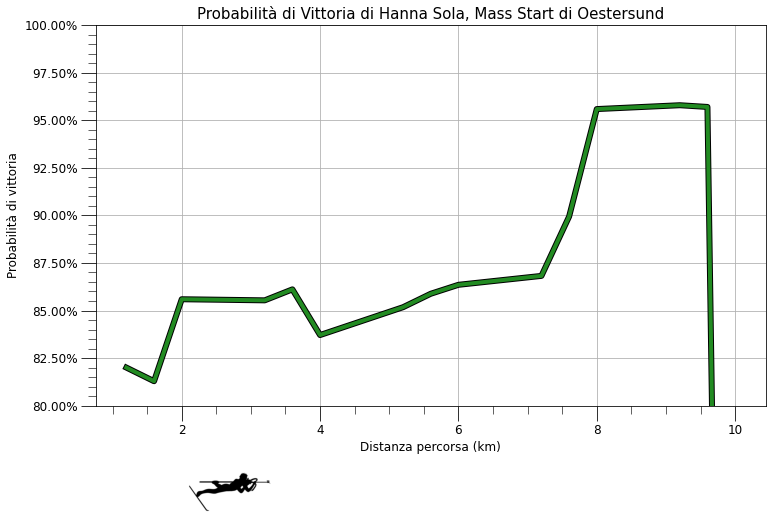

In [148]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
df_Sola = data_df_test_prob[data_df_test_prob.full_name == 'Hanna_Sola']
df_collapse = df_Sola[df_Sola.date_order == 177.0]

im = plt.imread('../../../prone.png')


fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse['distance']) + [10], list(df_collapse['Victory']) + [0], color = 'forestgreen', linewidth = 4, zorder = 3)
ax.plot(list(df_collapse['distance']) + [10], list(df_collapse['Victory']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(0.8, 1)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Hanna Sola, Mass Start di Oestersund', fontsize = 15)

left, bottom, width, height = (1/5) - 0.15/2, -0.3, 0.15, 0.15
ip = InsetPosition(ax, [left, bottom, width, height])
print(ip)


new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
new_ax1.imshow(im)
new_ax1.set_axes_locator(ip)

new_ax1.axis('off')





plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

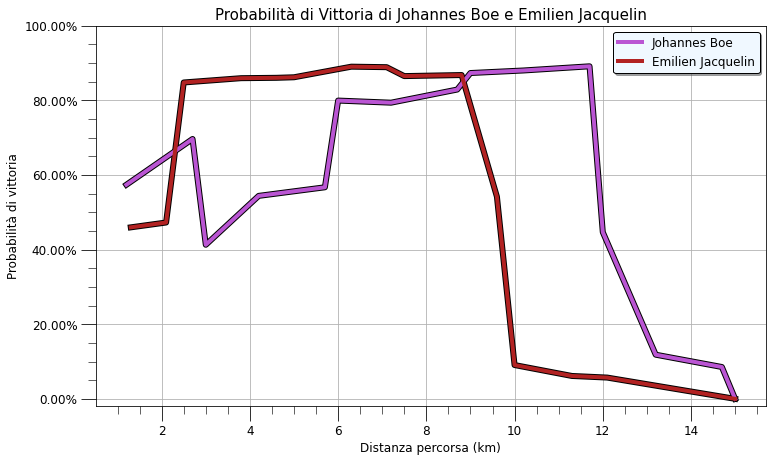

In [85]:
df_Boe = data_df_test_prob[data_df_test_prob.full_name == 'Johannes Thingnes_Boe']
df_collapse_Boe = df_Boe[df_Boe.date_order == 189.0]
df_Jac = data_df_test_prob[data_df_test_prob.full_name == 'Emilien_Jacquelin']
df_collapse_Jac = df_Jac[df_Jac.date_order == 174.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_Boe['distance']) + [15], list(df_collapse_Boe['Victory']) + [0], color = 'mediumorchid', linewidth = 4, zorder = 3, label = 'Johannes Boe')
ax.plot(list(df_collapse_Boe['distance']) + [15], list(df_collapse_Boe['Victory']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.plot(list(df_collapse_Jac['distance']) + [15], list(df_collapse_Jac['Victory']) + [0], color = 'firebrick', linewidth = 4, zorder = 3, label = 'Emilien Jacquelin')
ax.plot(list(df_collapse_Jac['distance']) + [15], list(df_collapse_Jac['Victory']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Johannes Boe e Emilien Jacquelin', fontsize = 15)
ax.legend(fontsize = 12, facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [61]:
data_df_test_prob[data_df_test_prob['Rank'] > 1 ].sort_values(by = 'Podium', ascending = False).head(20)

,index,full_name,distance,Rank,sex,Behind,format,season,date,date_order,...,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below,Victory,2-3_place,no_podium,Podium
30686,295385,Vetle Sjaastad_Christiansen,14.4,2,1,0.0,2,2021-2022,2021-11-27,170.0,...,2051.987316,0.0,16.738281,0.0,17.513644,0.0,0.850604,0.144299,0.005097,0.994903
20750,148864,Dzinara_Alimbekava,11.6,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2244.886045,0.0,15.176827,0.0,16.523136,0.0,0.897364,0.097054,0.005582,0.994418
20578,148692,Dzinara_Alimbekava,10.3,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2228.164790,0.0,15.202490,0.0,16.532981,0.0,0.898365,0.095973,0.005662,0.994338
20664,148778,Dzinara_Alimbekava,10.9,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2239.601636,0.0,15.184366,0.0,16.525324,0.0,0.898580,0.095608,0.005812,0.994188
20492,148606,Dzinara_Alimbekava,9.9,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2230.780072,0.0,15.205272,0.0,16.531717,0.0,0.894249,0.099690,0.006061,0.993939
9783,137897,Marte Olsbu_Roeiseland,3.0,2,0,0.0,1,2021-2022,2021-12-18,180.0,...,1153.862268,0.0,14.543638,0.0,15.480777,0.0,0.866290,0.127440,0.006270,0.993730
9731,137845,Marte Olsbu_Roeiseland,2.7,2,0,0.0,1,2021-2022,2021-12-18,180.0,...,1155.434956,0.0,14.547234,0.0,15.486722,0.0,0.866290,0.127440,0.006270,0.993730
9679,137793,Marte Olsbu_Roeiseland,2.0,2,0,0.0,1,2021-2022,2021-12-18,180.0,...,1137.174328,0.0,14.569848,0.0,15.505593,0.0,0.865289,0.128324,0.006387,0.993613
20320,148434,Dzinara_Alimbekava,9.0,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2081.582585,0.0,15.203892,0.0,16.559972,0.0,0.879918,0.113615,0.006467,0.993533
52899,317598,Johannes Thingnes_Boe,5.9,2,1,0.0,1,2021-2022,2022-02-13,195.0,...,2413.623173,0.0,14.190467,0.0,14.974982,0.0,0.845240,0.148165,0.006595,0.993405


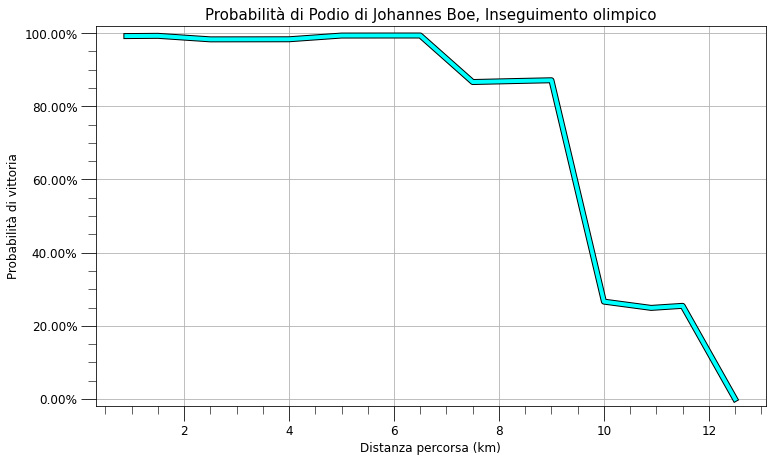

In [86]:
df_Boe = data_df_test_prob[data_df_test_prob.full_name == 'Johannes Thingnes_Boe']
df_collapse_Boe = df_Boe[df_Boe.date_order == 195.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_Boe['distance']) + [12.5], list(df_collapse_Boe['Podium']) + [0], color = 'aqua', linewidth = 4, zorder = 3, label = 'Johannes Boe')
ax.plot(list(df_collapse_Boe['distance']) + [12.5], list(df_collapse_Boe['Podium']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Johannes Boe, Inseguimento olimpico', fontsize = 15)

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

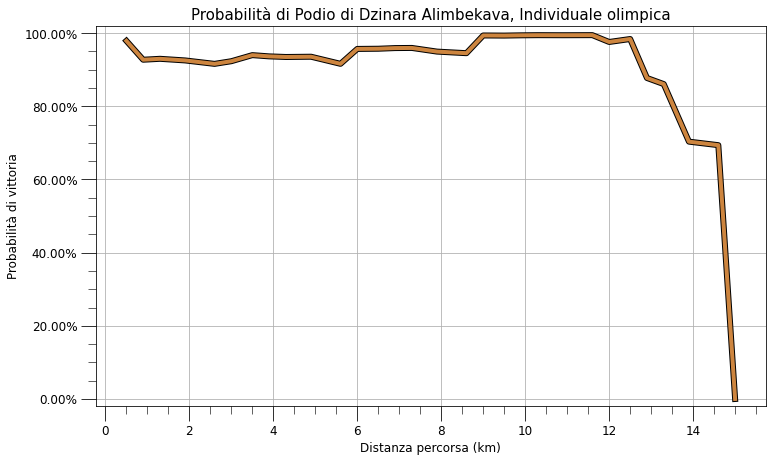

In [87]:
df_Alimbaekava = data_df_test_prob[data_df_test_prob.full_name == 'Dzinara_Alimbekava']
df_collapse_Ali = df_Alimbaekava[df_Alimbaekava.date_order == 191.0]
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(list(df_collapse_Ali['distance']) + [15], list(df_collapse_Ali['Podium']) + [0], color = 'peru', linewidth = 4, zorder = 3, label = 'Johannes Boe')
ax.plot(list(df_collapse_Ali['distance']) + [15], list(df_collapse_Ali['Podium']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Dzinara Alimbekava, Individuale olimpica', fontsize = 15)

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [64]:
data_df_test_prob[data_df_test_prob['Rank'] == 0 ].sort_values(by = 'Victory', ascending = True).head(20)

,index,full_name,distance,Rank,sex,Behind,format,season,date,date_order,...,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below,Victory,2-3_place,no_podium,Podium
43060,307759,Quentin_Fillon Maillet,2.5,0,1,87.0,1,2021-2022,2022-01-09,183.0,...,603.973611,-379.319194,13.011657,8.259368,14.248240,9.083847,0.015933,0.266492,0.717574,0.282426
43115,307814,Quentin_Fillon Maillet,3.1,0,1,90.8,1,2021-2022,2022-01-09,183.0,...,627.967067,-376.349330,13.152158,7.600629,14.383532,8.356684,0.024338,0.250115,0.725546,0.274454
41165,305864,Alexander_Loginov,0.3,0,1,2.5,0,2021-2022,2022-01-07,182.0,...,24.938678,-29.990200,10.989717,13.657205,12.400571,15.569538,0.037491,0.115766,0.846743,0.153257
45672,310371,Anton_Babikov,3.2,0,1,30.0,2,2021-2022,2022-01-20,187.0,...,148.344187,-129.182097,13.739766,11.154170,15.465823,12.123540,0.045673,0.332314,0.622013,0.377987
45768,310467,Anton_Babikov,3.7,0,1,35.3,2,2021-2022,2022-01-20,187.0,...,151.315054,-144.219645,14.141208,10.133283,15.716163,11.096589,0.049891,0.335789,0.614320,0.385680
43224,307923,Quentin_Fillon Maillet,5.6,0,1,96.1,1,2021-2022,2022-01-09,183.0,...,1030.265787,-286.756761,13.298050,5.584076,14.896503,6.034998,0.053006,0.293371,0.653623,0.346377
43167,307866,Quentin_Fillon Maillet,5.0,0,1,89.0,1,2021-2022,2022-01-09,183.0,...,963.496722,-276.168114,13.380295,5.584076,14.913821,6.034998,0.053060,0.378333,0.568607,0.431393
43282,307981,Quentin_Fillon Maillet,6.2,0,1,94.1,1,2021-2022,2022-01-09,183.0,...,1119.399243,-264.201933,13.257304,5.990587,14.733299,6.575627,0.061105,0.287693,0.651202,0.348798
45566,310265,Anton_Babikov,2.7,0,1,25.9,2,2021-2022,2022-01-20,187.0,...,117.033072,-102.251988,14.132600,10.147789,15.808673,11.043324,0.064815,0.400020,0.535164,0.464836
45463,310162,Anton_Babikov,2.3,0,1,23.1,2,2021-2022,2022-01-20,187.0,...,100.515551,-88.051263,14.127852,9.765970,15.733430,10.613781,0.073050,0.418242,0.508708,0.491292


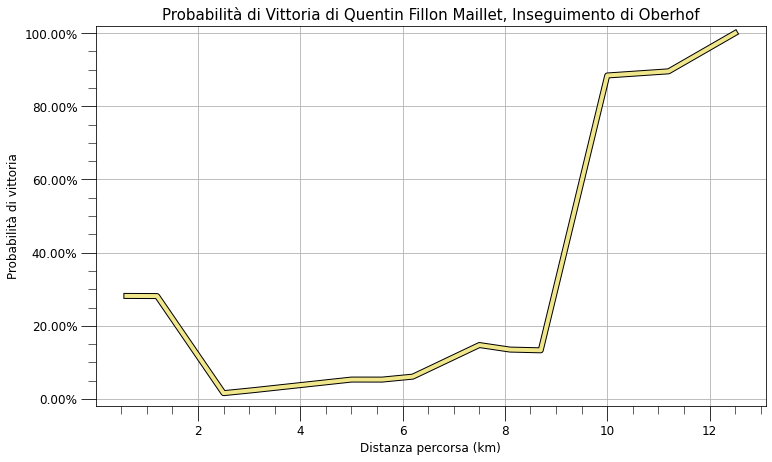

In [88]:
df_FM = data_df_test_prob[data_df_test_prob.full_name == 'Quentin_Fillon Maillet']
df_collapse_FM = df_FM[df_FM.date_order == 183.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_FM['distance']) + [12.5], list(df_collapse_FM['Victory']) + [1], color = 'khaki', linewidth = 4, zorder = 3, label = 'Quentin_Fillon')
ax.plot(list(df_collapse_FM['distance']) + [12.5], list(df_collapse_FM['Victory']) + [1], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Quentin Fillon Maillet, Inseguimento di Oberhof', fontsize = 15)

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

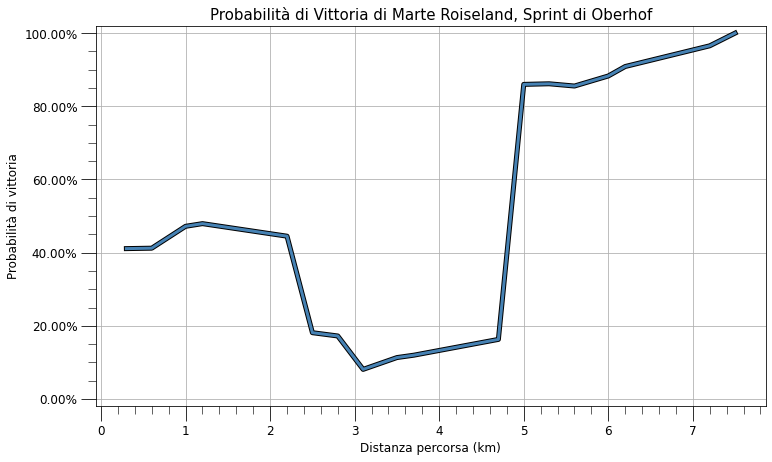

In [78]:
df_MR = data_df_test_prob[data_df_test_prob.full_name == 'Marte Olsbu_Roeiseland']
df_collapse_MR = df_MR[df_MR.date_order == 182.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_MR['distance']) + [7.5], list(df_collapse_MR['Victory']) + [1], color = 'steelblue', linewidth = 4, zorder = 3, label = 'Quentin_Fillon')
ax.plot(list(df_collapse_MR['distance']) + [7.5], list(df_collapse_MR['Victory']) + [1], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Marte Roiseland, Sprint di Oberhof', fontsize = 15)

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [67]:
data_df_test_prob[data_df_test_prob['Rank'] == 1 ].sort_values(by = 'Podium', ascending = True).head(20)

,index,full_name,distance,Rank,sex,Behind,format,season,date,date_order,...,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below,Victory,2-3_place,no_podium,Podium
15538,143652,Anton_Smolski,6.100000,1,0,74.5,1,2021-2022,2022-01-16,186.0,...,537.834354,-336.942231,13.358338,8.244599,14.266871,9.130245,0.004378,0.028175,0.967447,0.032553
25630,153744,Karoline Offigstad_Knotten,1.200000,1,0,15.6,0,2021-2022,2022-03-11,200.0,...,96.289031,-151.340027,11.918536,13.623751,13.262368,14.669236,0.007942,0.026893,0.965165,0.034835
11384,139498,Hanna_Sola,2.800000,1,0,48.9,0,2021-2022,2022-01-07,182.0,...,278.896567,-496.377549,13.098964,12.799090,14.944920,14.960527,0.008301,0.037370,0.954329,0.045671
25701,153815,Karoline Offigstad_Knotten,1.600000,1,0,17.6,0,2021-2022,2022-03-11,200.0,...,93.277149,-142.471528,13.046192,12.390561,14.858344,13.332983,0.007108,0.038607,0.954285,0.045715
25783,153897,Karoline Offigstad_Knotten,1.900000,1,0,19.3,0,2021-2022,2022-03-11,200.0,...,121.968472,-142.405058,13.367939,11.969556,15.213342,12.856308,0.008493,0.050344,0.941163,0.058837
11479,139593,Hanna_Sola,3.100000,1,0,54.2,0,2021-2022,2022-01-07,182.0,...,327.059275,-420.500378,12.761004,12.234999,15.541363,13.947728,0.014960,0.045812,0.939229,0.060771
11282,139396,Hanna_Sola,2.500000,1,0,48.9,0,2021-2022,2022-01-07,182.0,...,267.582705,-498.116339,12.836871,12.889896,14.847044,15.068166,0.008301,0.052826,0.938873,0.061127
15595,143709,Anton_Smolski,6.700000,1,0,72.0,1,2021-2022,2022-01-16,186.0,...,593.675324,-316.204296,13.474314,7.860578,14.363428,8.735898,0.008173,0.054518,0.937309,0.062691
22997,151111,Tiril_Eckhoff,8.000000,1,0,149.3,1,2021-2022,2022-02-13,195.0,...,1434.818703,-352.274694,13.800309,4.900233,15.081805,5.068873,0.014341,0.052598,0.933061,0.066939
25539,153653,Karoline Offigstad_Knotten,0.900000,1,0,10.3,0,2021-2022,2022-03-11,200.0,...,53.154547,-96.193260,12.595528,13.199344,14.249940,14.062647,0.016876,0.050371,0.932752,0.067248


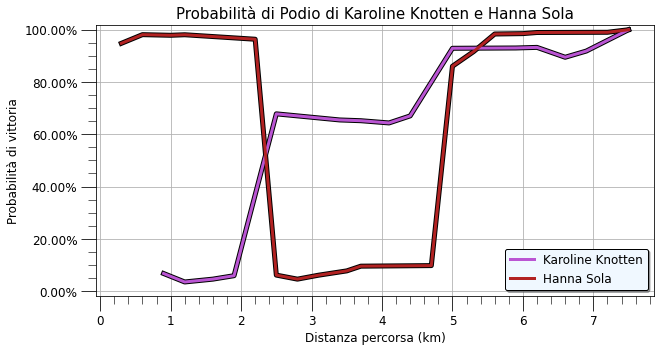

In [74]:
df_Knotten = data_df_test_prob[data_df_test_prob.full_name == 'Karoline Offigstad_Knotten']
df_collapse_Kn = df_Knotten[df_Knotten.date_order == 200.0]
df_Hanna = data_df_test_prob[data_df_test_prob.full_name == 'Hanna_Sola']
df_collapse_HS = df_Hanna[df_Hanna.date_order == 182.0]
fig, ax = plt.subplots(figsize=(12 ,7))

ax.plot(np.array(list(df_collapse_Kn['distance']) + [7.5]), np.array(list(df_collapse_Kn['Podium']) + [1]), color = 'mediumorchid', linewidth = 4, zorder = 3, label = 'Karoline Knotten')
ax.plot(np.array(list(df_collapse_Kn['distance']) + [7.5]), np.array(list(df_collapse_Kn['Podium']) + [1]), color = 'black', linewidth = 6, zorder = 2)
ax.plot(np.array(list(df_collapse_HS['distance']) + [7.5]), np.array(list(df_collapse_HS['Podium']) + [1]), color = 'firebrick', linewidth = 4, zorder = 3, label = 'Hanna Sola')
ax.plot(np.array(list(df_collapse_HS['distance']) + [7.5]), np.array(list(df_collapse_HS['Podium']) + [1]), color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Karoline Knotten e Hanna Sola', fontsize = 15)
ax.legend(fontsize = 12, facecolor = 'aliceblue', shadow = True, edgecolor = 'black')

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

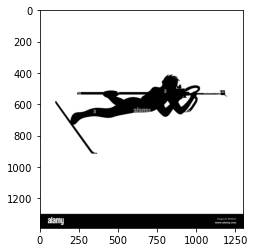

In [6]:
prone = cv2.imread('../../../prone_position.jpeg')
prone_gs = cv2.cvtColor(prone, cv2.COLOR_BGR2GRAY)
plt.imshow(prone_gs, cmap = 'gray')

In [7]:
def cv_tresholding(img, threshold):
    img = img.copy()
    img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)[1]
    return img

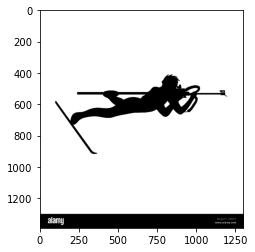

In [11]:
thresholded_prone = cv_tresholding(prone_gs, 200)
height, width = thresholded_prone.shape
plt.imshow(thresholded_prone, cmap = 'gray')


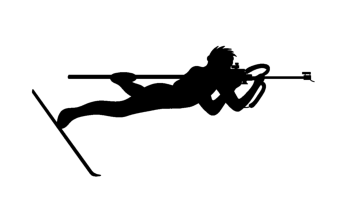

In [93]:

# Crop image
thresholded_prone_cropped = thresholded_prone[0: width, :]
height, width = thresholded_prone_cropped.shape
thresholded_prone_cropped = thresholded_prone[int(height * 0.2) : int(height * 0.8), int(width * 0) : int(width * 1)]
thresholded_prone_cropped.shape
plt.imshow(thresholded_prone_cropped, cmap = 'gray')
plt.axis('off')
plt.savefig('/Users/tommaso/Desktop/BiathlonAzzurroWrapper/prone.png', bbox_inches = 'tight', pad_inches = 0)


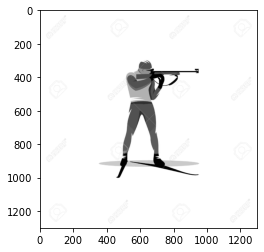

In [28]:
standing = cv2.imread('../../../standing.jpeg')
standing_gs = cv2.cvtColor(standing, cv2.COLOR_BGR2GRAY)
plt.imshow(standing_gs, cmap = 'gray')

In [130]:
df_Smolski = data_df_test_prob[data_df_test_prob.full_name == 'Anton_Smolski']
df_collapse_Sm = df_Smolski[df_Smolski.date_order == 186.0]
fig, ax = plt.subplots(figsize=(12 ,7))
idx = np.argsort(list(df_collapse_Sm['distance']) + [12.5])
ax.plot(np.array(list(df_collapse_Sm['distance']) + [12.5])[idx], np.array(list(df_collapse_Sm['Podium']) + [1])[idx], color = 'forestgreen', linewidth = 4, zorder = 3, label = 'Quentin_Fillon')
ax.plot(np.array(list(df_collapse_Sm['distance']) + [12.5])[idx], np.array(list(df_collapse_Sm['Podium']) + [1])[idx], color = 'black', linewidth = 6, zorder = 2, label = 'Quentin_Fillon')
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Anton Smolski, Inseguimento di Ruhpolding', fontsize = 15)

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

[1.1, 1.7, 3.6, 4.2, 6.1, 6.7, 8.6, 9.2, 11.1, 11.7, 2.5, 5.0, 7.5, 10.0]